# RateML on HPC

### Launch the CUDA model with Pyunicore on HPC cluster

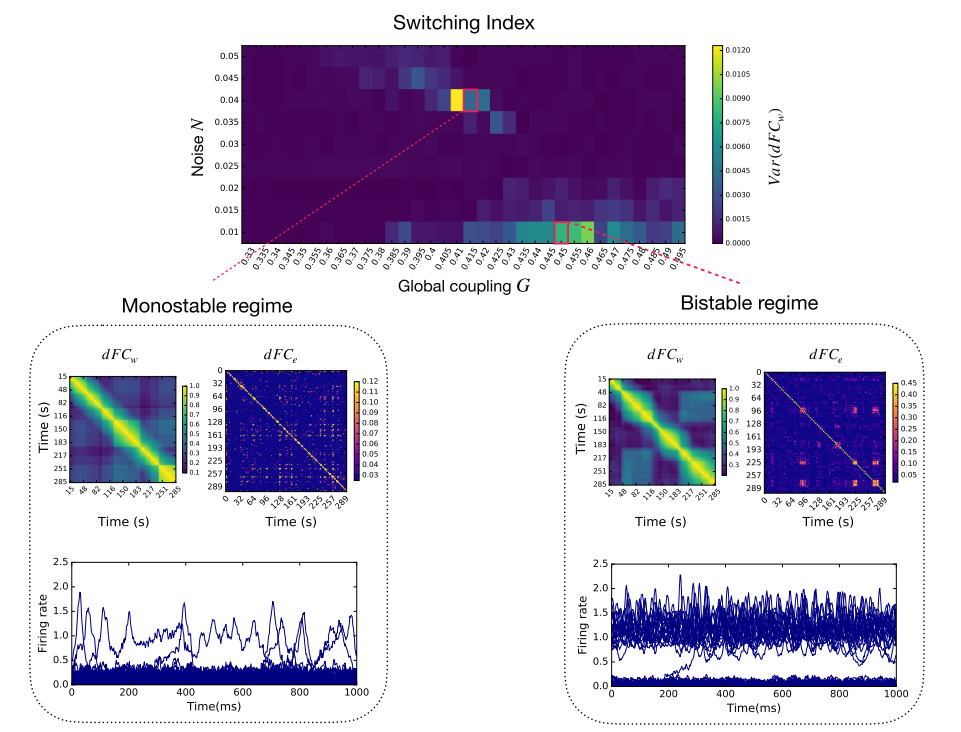

In [1]:
from IPython.display import Image
from IPython.core.display import HTML
Image(filename = "/opt/app-root/src/drive/My Libraries/main/images/montbriosweep.png", width=800, height=800)

Taken from: \
Rabuffo, G., Fousek, J., Bernard, C., and Jirsa, V. (2021). Neuronal Cascades Shape Whole-Brain Functional Dynamics at Rest. eNeuro 8, 0283–321. doi:10.1523/ ENEURO.0283-21.2021 

The goal here is to mimic the above parameters exploration experiment. We will setup up a parameter sweep using the GPU on HPC. The generated model for Python will now be enhanced with option to simulate it for multiple parameters in a single go. 

In [2]:
import json
import os

RMLROOT = "/opt/app-root/src/drive/My Libraries/main/tvb-root/tvb_library/tvb/rateML/"
CNSROOT = "/opt/app-root/src/drive/My Libraries/main/"
REMOTE_RML_ROOT = "/tvb-root/tvb_library/tvb/rateML/"
INSTALL_ROOT = "/opt/app-root/src/.local/lib/python3.8/site-packages/tvb/rateML/"

### Set generated model name
This variable sets the model for simulation on HPC for this notebook. If you ever make an own .xml file for model generation with RateML, MODEL_NAME needs to be identical to its name without the ".xml" extension. For this session we will use "montbrio" and "zerlaut". 

In [3]:
# MODEL_NAME = "zerlaut"
MODEL_NAME = "montbrio"

The model we generated can be found here: rateML/generatedModels

## Simulating the generated model on HPC
If the model displays all its features to your whishes, it is time to take her for a spin on a GPU. The sites that are tested to run the models are the JUSUF and JUWELS clusters from Forschungszentrum Juelich. This will only work if you have registered in JUDOOR application and have acquired a budget for simulation. Else this step will not succeed.

In [9]:
import json
import os
import pyunicore.client as unicore_client
# !pip install pyunicore --upgrade

token = clb_oauth.get_token()
tr = unicore_client.Transport(token)
r = unicore_client.Registry(tr, unicore_client._HBP_REGISTRY_URL)
HPC_LOC = "https://zam2125.zam.kfa-juelich.de:9112/JUSUF/rest/core"

# Enter your project below, 'icei-hbp-2021-0003' is an example LDAP project
# PROJECT = '!!enter your project here!!'
PROJECT = 'icei-hbp-2021-0003'
tr.preferences="group:" + PROJECT
site = unicore_client.Client(transport=tr,site_url=HPC_LOC)
USER = site.access_info()['xlogin']['UID']

STOR_LOC = 'https://zam2125.zam.kfa-juelich.de:9112/JUDAC/rest/core'
base_url = STOR_LOC + "/storages/PROJECT/"
storage = unicore_client.Storage(tr, base_url)

site.access_info()
# r.site_urls
# site.get_storages()

{'role': {'selected': 'user', 'availableRoles': ['user']},
 'queues': {'availableQueues': ['batch', 'gpus', 'develgpus'],
  'selected': 'batch'},
 'dn': 'UID=m.van.der.vlag@fz-juelich.de',
 'xlogin': {'UID': 'vandervlag1',
  'availableGroups': ['icei-hbp-2021-0003', 'icei-hbp-2021-0012', 'cslns'],
  'availableUIDs': ['vandervlag1'],
  'group': 'icei-hbp-2021-0003'}}

### Transfer model
Transfer the generated model file to JUSUF.

In [23]:
# transfer the generated model
MODLOC = "generatedModels/" + MODEL_NAME + ".c"
source = RMLROOT + MODLOC
destination = USER + REMOTE_RML_ROOT + MODLOC
storage.upload(source, destination)

In [24]:
# transfer the generated driver
DRVLOC = "run/model_driver_" + MODEL_NAME + ".py"
source = INSTALL_ROOT + DRVLOC
# source_path = os.path.join(os.environ['HOME'], source_location_driver)
destination = USER + REMOTE_RML_ROOT + DRVLOC
storage.upload(source, destination)

### Job setup

Before the can be executed on HPC some other arguments need to be set:

python model_driver.py [-h] [-s0 N_SWEEP_ARG0] [-s1 N_SWEEP_ARG1] [-s2 N_SWEEP_ARG2] [-n N_TIME] [-v] [--model MODEL]
[-st STATES] [-ex EXPOSURES] [--lineinfo] [-bx BLOCKSZX] [-by BLOCKSZY] [-val] [-tvbn N_TVB_BRAINNODES] [-p] [-w] [-g]

We will set the most important ones. Many of them are already set in the driver file. 
* -s0 .. -sN arguments set the resolution of sweep paramters for the Zerlaut model:
        <Parameter name="global_coupling" dimension='0, 0.5'/>
        <Parameter name="b_e" dimension='0, 120'/>
        <Parameter name="E_L_e" dimension='-80, -60'/>
        <Parameter name="E_L_i" dimension='-80, -60'/>
        <Parameter name="T" dimension='5, 40'/>
* -n sets the simulation steps 
* -dt sets the duration of a time (integration) step
* -sm --speeds_min min speed for temporal buffer
* -v gives verbose information on the simulation
* -w writes tavg to disk


Lets setup a bash file to start the HPC parameter job. This file needs to be transferred and executed on the HPC system.
Open de jusuf.sh file to set the parameters for the model. The content should look as below. The #SBATCH parameters set the properties for HPC simulation; these should work as they are. The srun command execute the TVB HPC driver which we transferred earlier. It takes arguments for settings resolution of the parameter ranges '-s0 .. -sN', the simulation steps '-n' , duration of s single time step '-dt', minimum connection speed length to determine minimum buffer '-sm', verbose output '-v', write the output to file '-w' and set the exposure to 7 with -x7.

### Transfer the bash file to HPC

In [19]:
source = CNSROOT + "/jusuf.sh"
# source_path = os.path.join(os.environ['HOME'], source_location_bash)
destination = USER + "/jusuf.sh"
storage.upload(source, destination)

### Start the job on HPC:
SLURM does not support using variables in the #SBATCH lines within a job script. However, values passed from the command line have precedence over values defined in the job script. So the job name and output/error files can be passed on the sbatch command line. The environment and submitting the sbatch script are set in the same executable entry. 


In [20]:
my_job = {}
my_job['Executable'] = "source $PROJECT/$USER/activate.sh; sbatch -o $PROJECT/$USER/output.out -e $PROJECT/$USER/error.er $PROJECT/$USER/jusuf.sh"
my_job['RunOnLoginNode'] = "true"
my_job['Job type'] = "interactive"
my_job

{'Executable': 'source $PROJECT/$USER/activate.sh; sbatch -o $PROJECT/$USER/output.out -e $PROJECT/$USER/error.er $PROJECT/$USER/jusuf.sh',
 'RunOnLoginNode': 'true',
 'Job type': 'interactive'}

#### Submit Job to selected HPC cluster 

In [25]:
job = site.new_job(job_description=my_job)

job.poll()

result_job = {}
wd = job.working_dir
result_job["stderr"] = [x.decode('utf8') for x in wd.stat("/stderr").raw().readlines()]
result_job["stdout"] = [x.decode('utf8') for x in wd.stat("/stdout").raw().readlines()]
result_job

{'stderr': [], 'stdout': ['Submitted batch job 364523\n']}

### Info about the submitted JOB

### Fetch results
Copy the output log from cluster to Collab

In [26]:
remote = storage.stat(USER + "/output.out")
remote.download(CNSROOT + "/data/output.out")
    
with open(CNSROOT + "/data/output.out", "r") as f:
    for line in f:
        print (line.rstrip())

WARNING  File 'hemispheres' not found in ZIP.
   INFO  dt 0.100000
   INFO  n_nodes 76
   INFO  weights.shape (76, 76)
   INFO  lengths.shape (76, 76)
   INFO  tavg period 1.0
   INFO  n_inner_steps 10
   INFO  params shape (5, 1)
   INFO  nstep 400
   INFO  n_inner_steps 10.000000
   INFO  real buf_len 512, using power of 2 1024
   INFO  number of states 2
   INFO  model montbrio
   INFO  real buf_len 512, using power of 2 1024
   INFO  memory for states array on GPU 2 MiB
   INFO  nvcc options ['--ptxas-options=-v', '-maxrregcount=32', '-DWARP_SIZE=32', '-DNH=1024']
   INFO  history shape (1024, 152, 5)
   INFO  gpu_data (2, 76, 5)
   INFO  on device mem: 3.063 MiB
   INFO  final block dim (8, 8, 1)
   INFO  final grid dim (1, 1)

==============NVSMI LOG==============

Timestamp                                 : Wed Sep 28 16:52:53 2022
Driver Version                            : 515.65.01
CUDA Version                              : 11.7

Attached GPUs                             : 1

Copy the error log from JUSUF to Collab

In [27]:
# get the stderr dump if needed
remote = storage.stat(USER + "/error.er")
remote.download(CNSROOT + "/data/error.er")

with open(CNSROOT + "/data/error.er", "r") as f:
    for line in f:
        print (line.rstrip())

/p/project/training2221/vandervlag1/tvb-root/tvb_library/tvb/datatypes/surfaces.py:64: UserWarning: Geodesic distance module is unavailable; some functionality for surfaces will be unavailable.
  warnings.warn(msg)


#### Transfer the produced data from HPC and unpickle it

In [28]:
# download the pickled results file
remote = storage.stat(USER + REMOTE_RML_ROOT + "run/tavg_data")
remote.download(CNSROOT + "/data/tavg_data")

In [29]:
import pickle
import numpy, sys

# numpy.set_printoptions(threshold=sys.maxsize)
tavg_file = open("data/tavg_data", 'rb')
tavg_data1 = pickle.load(tavg_file)
tavg_file.close()
# tavg_data(simsteps, states, nodes, paramscombi)
tavg_data1.shape

(400, 2, 76, 5)

### Plot the montbrio data

(400, 2, 76, 5)
0


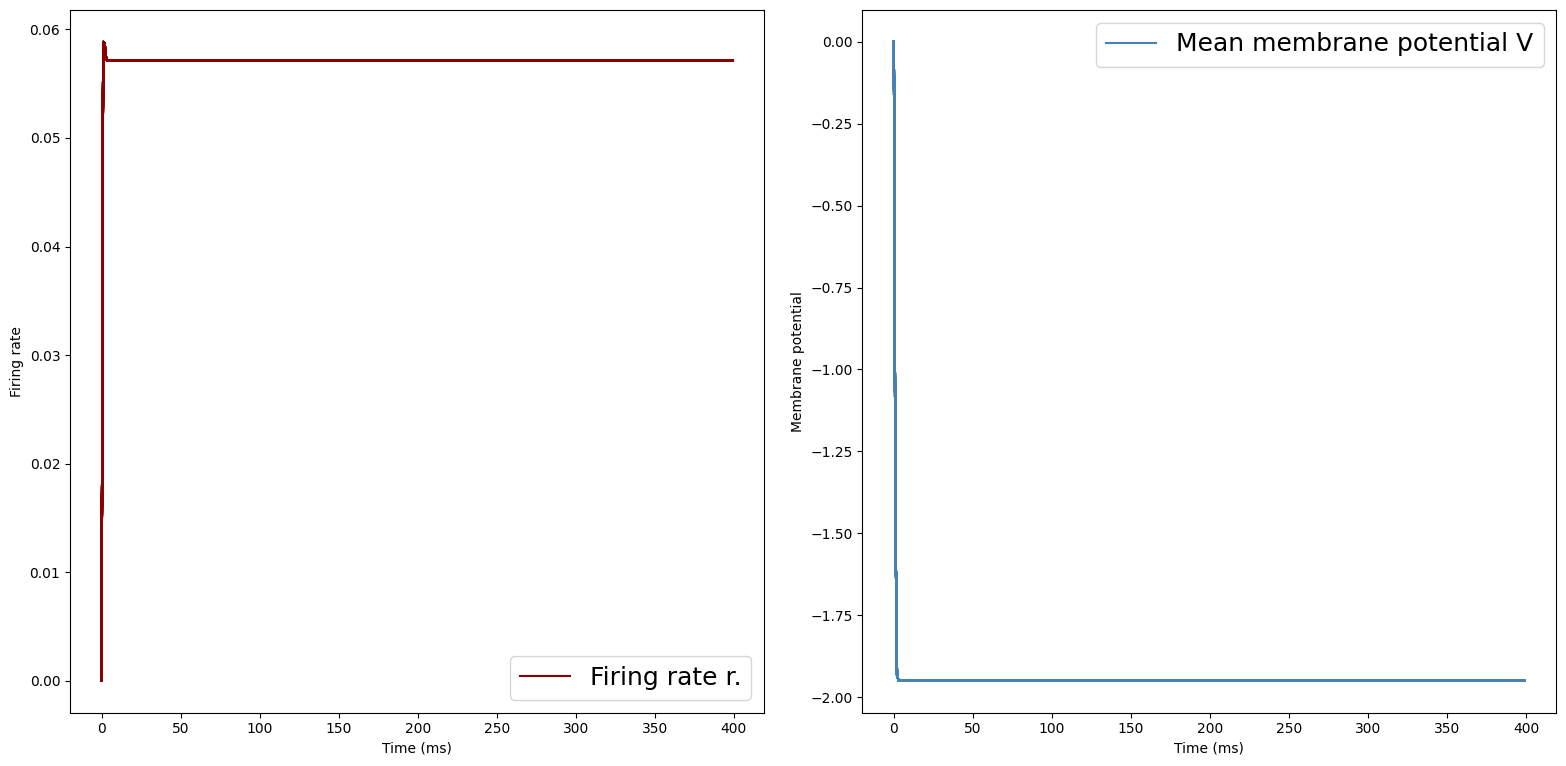

In [30]:
# demo data for the params for synchronous behavior at b = 60 pA first state variable showing the exitatory firing rate. 
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.pylab as pyt
from IPython.display import clear_output
from IPython import display
import time

filename = "data/tavg_data"
tavg_file = open(filename, 'rb')
tavg_data1 = pickle.load(tavg_file)
tavg_file.close()

# n_params = range(len(tavg_data1[0, 0, 0, :]))
n_params = 0

print(tavg_data1.shape)

time_s = range(len(tavg_data1[:, 0, 0, 0]))
data = tavg_data1

fig, axes = plt.subplots(1,2,figsize=(16,8))
plt.rcParams.update({'font.size': 18})
    
'''plot traces'''
Li = axes[0].plot(time_s,data[:, 0, :, n_params],color='darkred') # [times, regions]
Le = axes[1].plot(time_s,data[:, 1, :, n_params],color='SteelBlue') # [times, regions]

axes[0].set_xlabel('Time (ms)')
axes[1].set_xlabel('Time (ms)')

axes[0].set_ylabel('Firing rate')
axes[1].set_ylabel('Membrane potential')

# axes[0,simnum].set_ylim([-15,55])
axes[0].legend([Li[0]], ['Firing rate r.'], loc='best')
axes[1].legend([Le[0]], ['Mean membrane potential V'], loc='best')

# for ax in axes.reshape(-1):
#     ax.set_xlim([3,5])
#     ax.set_xticks([3,3.5,4,4.5,5])


print(n_params)
plt.tight_layout()
plt.show()
    

## Adaptive Exponential model usings Zerlaut equations

Lets now focus on a more complex TVB model which uses 7 states to integrate across scales using mean-field modeling of Adaptive Exponential (AdEx) neurons, explicitly incorporating intrinsic properties of excitatory and inhibitory neurons. When a realistic human connectome is used to connect the AdEx mean-field neural populations, macroscopic dynamics resembling human brain activity emerge. This model can qualitatively and quantitatively account for properties of empirical spontaneous and stimulus-evoked dynamics in the space, time, phase, and frequency domains.

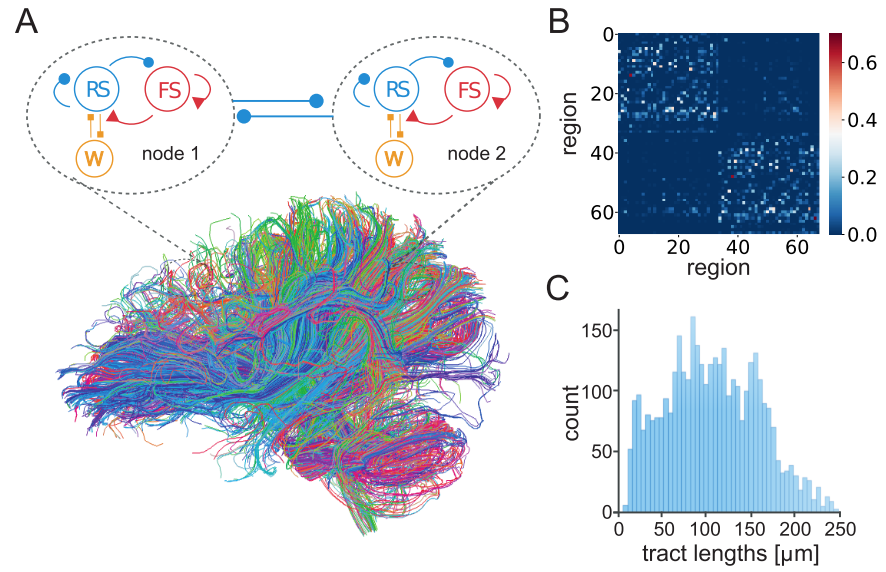

In [82]:
Image(filename = "/opt/app-root/src/drive/My Libraries/CNS satellite/images/figure_Goldman.png", width=800, height=800)

Figure 2. Connection of AdEx mean-field models in The Virtual Brain. (A) Each mean-field model consists of two populations, excitatory RS (blue) and inhibitory FS (red) neurons (as in Fig.1H), taking into account spike-frequency adaptation for excitatory neurons (W, orange). Mean-field models represent the mesoscopic scale, here comprising each of 68 defined regions of cerebral cortex. Brain regions are connected by excitatory tracts (thick blue lines) following structural connectomes [24]. (B) Number of fibers connecting brain regions in tractography data, divided by the sum of the gray matter volume of regions in anatomical MRI, is used to define connectivity weights between nodes. (C) The distribution of tract lengths in tractography data informs delays between TVB-AdEx model nodes. (Jennifer S. Goldman, Lionel Kusch, Bahar Hazal Yalc¸inkaya, Damien Depannemaecker, Trang-Anh E. Nghiem, Viktor Jirsa, and Alain Destexhe; A comprehensive neural simulation of slow-wave sleep and highly responsive wakefulness dynamics (2021); Unpublished, https://doi.org/10.1101/2021.08.31.458365).

### Because this model is complex, RateML cannot (yet) be used to fully generate this TVB model. 
The biggest issue is that rateML cannot deal with functioning. Inlining all this information is possible but unbearable. RateML can help though to start modeling this file. A HPC GPU model is already available and we can use the same pyunicore script above to lauch this model. 

### Original sweep values
global_coupling = [0, 0.5] \
b_e = [0, 120] \
E_L_e = [-80, -60] \
E_L_i = [-80, -60] \
T = [5, 40]

### Plot the Zerlaut data

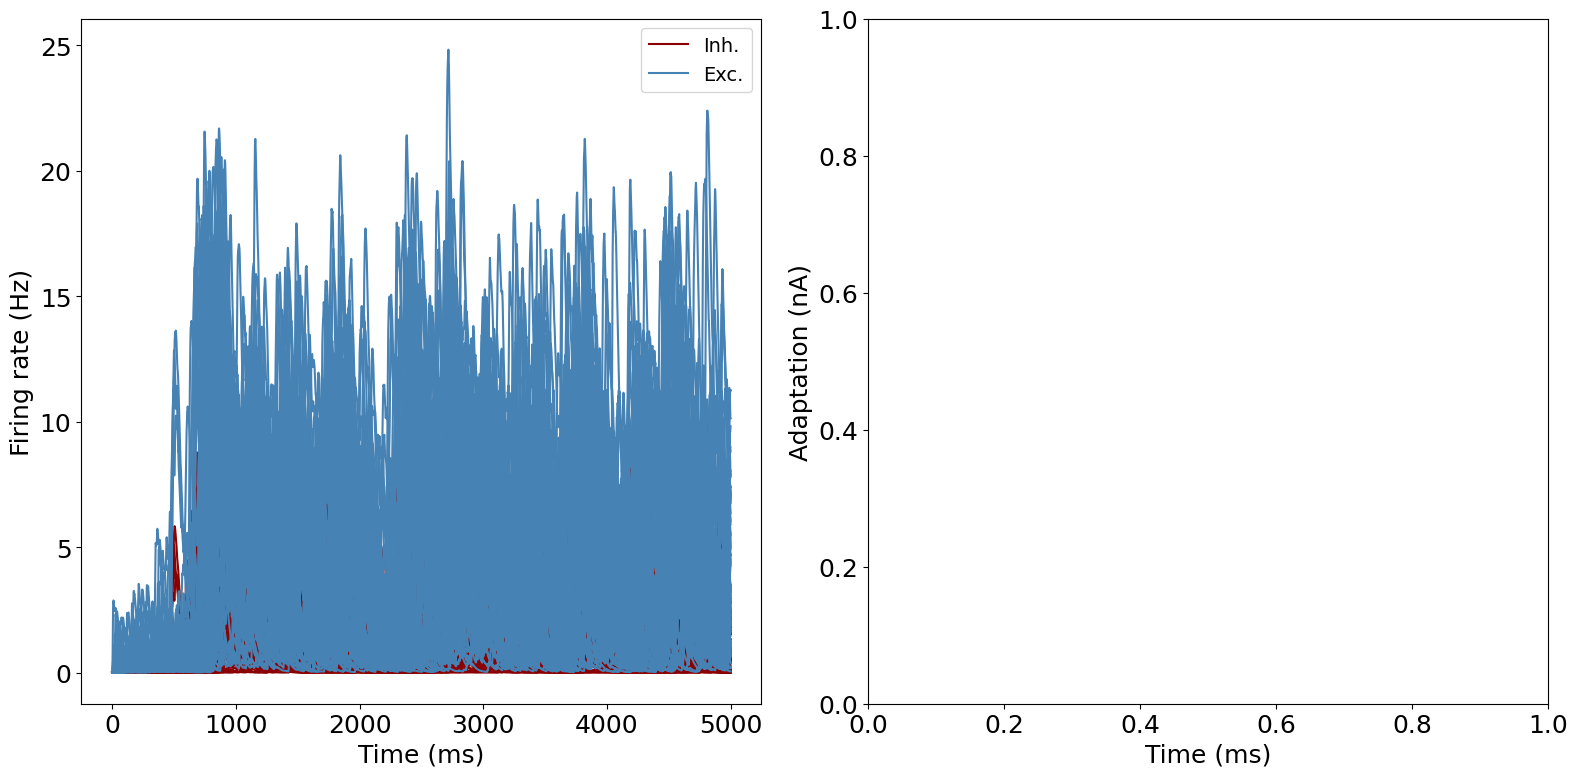

In [31]:
import matplotlib.pyplot as plt
%matplotlib inline

# demo
filename = "data/tavg_data_zerlaut_demo"
# filename = "data/tavg_data"
tavg_file = open(filename, 'rb')
tavg_data1 = pickle.load(tavg_file)
tavg_file.close()

FR_exc = []
FR_inh = []
Ad_exc = []

n_params = 0

'''fill variables'''
# time_s = result[0][0]*1e-3 #from ms to sec
time_s = range(len(tavg_data1[:, 0, 0, 0]))
FR_exc = tavg_data1[:, 0, :, n_params]*1e3 # from KHz to Hz; Excitatory firing rate
FR_inh = tavg_data1[:, 1, :, n_params]*1e3 # from KHz to Hz; Inhibitory firing rate
# Ad_exc = tavg_data1[:, 5, :, n_params] # nA; Excitatory adaptation

fig, axes = plt.subplots(1,2,figsize=(16,8))

plt.rcParams.update({'font.size': 14})

bvals = [0]
# simname = ['asynchronous','synchronous']

for simnum in range(len(bvals)):
    
    '''plot traces'''
    Li = axes[0].plot(time_s, FR_exc,color='darkred') # [times, regions]
    Le = axes[0].plot(time_s, FR_inh,color='SteelBlue') # [times, regions]

    # axes[1].plot(time_s,Ad_exc,color='goldenrod') # [times, regions]

    axes[0].set_xlabel('Time (ms)')
    axes[1].set_xlabel('Time (ms)')

    axes[0].set_ylabel('Firing rate (Hz)')
    axes[1].set_ylabel('Adaptation (nA)')

    # axes[0].set_ylim([-15,40])
    axes[0].legend([Li[0], Le[0]], ['Inh.','Exc.'], loc='best')
    
    # for ax in axes.reshape(-1):
    #     ax.set_xlim([3,5])
    #     ax.set_xticks([3,3.5,4,4.5,5])

plt.tight_layout()
plt.show()
